## Новый код


### Create train and val datasets

In [23]:
import numpy as np

In [34]:
step = 50
im_shape=(401,701)
split_test=0.3
iline, xline = im_shape
vert_locations = np.arange(0, iline, step)
horz_locations = np.arange(0, xline, step)

In [37]:
vert_mask = np.array(vert_locations) % round(1 / split_test) * step == 0

In [39]:
horz_mask = np.array(horz_locations) % round(1 / split_test) * step == 0

In [55]:
p_tr_list = ['i_' + str(ii) for ii in vert_locations[~vert_mask]] + ['x_' + str(ii) for ii in horz_locations[~horz_mask]]

In [56]:
p_vl_list = ['i_' + str(ii) for ii in vert_locations[vert_mask]] + ['x_' + str(ii) for ii in horz_locations[horz_mask]]

In [58]:
import random

In [61]:
random.shuffle(p_tr_list)
random.shuffle(p_vl_list)

In [63]:
from os.path import join as pjoin
import os

In [67]:
path_data = 'data'

In [68]:
path_splits = pjoin(path_data, 'splits')
    
if not os.path.exists(path_splits):
    os.makedirs(path_splits)

In [69]:
file_object = open(pjoin(path_splits, 'train.txt'), 'w')
file_object.write('\n'.join(p_tr_list))
file_object.close()

file_object = open(pjoin(path_splits, 'val.txt'), 'w')
file_object.write('\n'.join(p_vl_list))
file_object.close()

### Трансформация (кроп) torchvision transforms

In [70]:
import torch
import torchvision

### Делаем загрузчик данных

In [1]:
import torch
from torch.utils.data import Dataset
from os.path import join as pjoin
import numpy as np
import cv2
from keras.utils import to_categorical

In [2]:
import torch.nn as nn
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

In [3]:
from torch.backends import cudnn

In [4]:
class MyDataset(Dataset):
    def __init__(self, split='train', loc='data/'):
        self.root = loc
        self.split = split
        self.n_classes = 6 
        
        self.seismic = np.load(pjoin(self.root,'train','train_seismic.npy'))
        self.labels  = np.load(pjoin(self.root,'train','train_labels.npy'   ))
        self.labels  = to_categorical(self.labels,num_classes=self.n_classes)

        path = pjoin(self.root, 'splits', 'section_' + self.split + '.txt')
        patch_list = tuple(open(path, 'r'))
        self.patch_list = patch_list

    def __len__(self):
        return len(self.patch_list)
    
    def __getitem__(self, index):
        indexes = self.patch_list[index]
        direction, number = indexes.split(sep='_')
        
        if direction == 'i':
            im = self.seismic[int(number),:,:]
            lbl = self.labels[int(number),:,:,:]
        elif direction == 'x':    
            im = self.seismic[:,int(number),:]
            lbl = self.labels[:,int(number),:,:]
        '''
        if im.shape[0] == 701:
            im = cv2.resize(im,(256,704))
            # lbl = np.argmax(cv2.resize(lbl,(256,704)),axis=-1)
            lbl = np.round(cv2.resize(lbl,(256,704)))
        else:
            im = cv2.resize(im,(256,416))
            # lbl = np.argmax(cv2.resize(lbl,(256,416)),axis=-1)
            lbl = np.round(cv2.resize(lbl,(256,416)))
        '''
        im = cv2.resize(im,(256,416)) # выбрать единый размер для i и x
        # lbl = np.argmax(cv2.resize(lbl,(256,416)),axis=-1)
        lbl = np.round(cv2.resize(lbl,(256,416))) # выбрать единый размер

        im = np.expand_dims(im, axis = 0)

        # Преобразование изображения и метки в тензоры PyTorch
        image_tensor = torch.from_numpy(im).float()
        label_tensor = torch.from_numpy(lbl).int()

        return image_tensor, label_tensor

In [5]:
train_dataset = MyDataset(split='train')
val_dataset = MyDataset(split='val')

In [6]:
batch_size = 8
num_epochs = 10


In [7]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [8]:
image_tensor, label_tensor = next(iter(train_loader))

In [11]:
import matplotlib.pyplot as plt

In [19]:
len(train_loader)

97

In [20]:
image_tensor.shape, label_tensor.shape

(torch.Size([8, 1, 704, 256]), torch.Size([8, 704, 256, 6]))

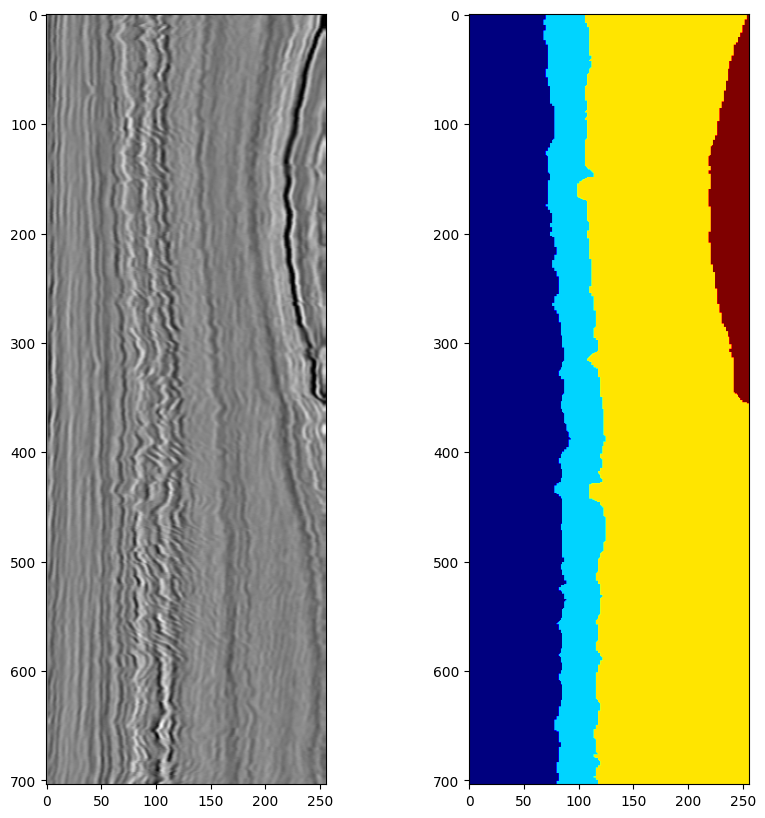

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
axs[0].imshow(image_tensor[0,0,:,:], cmap='gray')
axs[1].imshow(np.argmax(label_tensor[0,:,:,:],axis=-1), cmap='jet')
# axs[1].imshow(labels[idx,:,:].T, cmap='jet')
plt.show()

In [29]:
image_tensor.max(), image_tensor.min() # нормировка должна быть внутри класса

(tensor(1.), tensor(-1.))

### Моделька

In [ ]:
# random crop from torchvision transforms

In [34]:
# Создаем U-Net модель с энкодером resnet34
model = smp.Unet(
    encoder_name="resnet34", # resnet18 
    encoder_weights="imagenet", # можно обучать с нуля
    in_channels=1,
    classes=6  # Количество классов для сегментации
)

In [33]:
import segmentation_models_pytorch.utils

In [9]:
# Определяем функцию потерь и оптимизатор
loss = smp.utils.losses.DiceLoss() # указать количество классов?
metrics = [smp.utils.metrics.IoU(threshold=0.5)] # threshold ?? 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
# # Функция для выполнения обучения на одной эпохе
# def train_epoch(model, data_loader, loss_fn, optimizer):
#     model.train()
#     epoch_loss = 0.0
#     for images, masks in data_loader:
#         optimizer.zero_grad()
#         images = images.to(device)
#         masks = masks.to(device)

#         outputs = model(images)
#         loss = loss_fn(outputs, masks)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()

#     return epoch_loss / len(data_loader)

In [11]:
# # Функция для выполнения валидации на одной эпохе
# def validate_epoch(model, data_loader, loss_fn):
#     model.eval()
#     epoch_loss = 0.0
#     with torch.no_grad():
#         for images, masks in data_loader:
#             images = images.to(device)
#             masks = masks.to(device)

#             outputs = model(images)
#             loss = loss_fn(outputs, masks)
#             epoch_loss += loss.item()

#     return epoch_loss / len(data_loader)

In [12]:
# Определяем устройство для обучения
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
# Переносим модель и функцию потерь на устройство
model = model.to(device)
loss = loss.to(device)

In [14]:
from tqdm import tqdm

In [15]:
for epoch in tqdm(range(num_epochs), desc='Epochs'):
    # Обучение
    model.train()
    # i = 0
    # train_bar = tqdm(train_loader, desc='Training', leave=False)
    for images, labels in train_loader:
        # print(f'input shape = {(images.shape, labels.shape)}')
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        # print(f'output shape = {(outputs.shape)}')
        # print(f'lab_cat shape = {labels.shape}')
        # print(outputs[0,:,0,:10])
        # print(labels[0,0,:10,:])

        loss_value = loss(outputs, labels.reshape(outputs.shape))
        loss_value.backward()
        optimizer.step()
        # i += 1
        # train_bar.set_postfix(training_step=i)
    
    # Валидация
    model.eval()
    total_metric = 0
    num_samples = 0
    # val_bar = tqdm(val_loader, desc='Validation', leave=False)
    # i = 0
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            outputs = model(images)
            metric_value = metrics[0](outputs, labels.reshape(outputs.shape))
            total_metric += metric_value.item() * images.size(0)
            num_samples += images.size(0)
        # i += 1
        # val_bar.set_postfix(training_step=i)
    
    average_metric = total_metric / num_samples
    
    # Вывод прогресса обучения
    print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss_value.item():.4f}, Metric: {average_metric:.4f}')

    # сохранение чекпойнта (если метрика стала лучше)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epochs:  10%|█         | 1/10 [17:04<2:33:44, 1024.96s/it]

Epoch: 1/10, Loss: 1.2813, Metric: 0.0417


Epochs:  20%|██        | 2/10 [34:04<2:16:15, 1021.89s/it]

Epoch: 2/10, Loss: 0.6525, Metric: 0.0490


Epochs:  30%|███       | 3/10 [52:11<2:02:39, 1051.39s/it]

Epoch: 3/10, Loss: 0.7785, Metric: 0.1330


Epochs:  40%|████      | 4/10 [1:09:59<1:45:47, 1057.87s/it]

Epoch: 4/10, Loss: 0.7639, Metric: 0.1383


Epochs:  50%|█████     | 5/10 [1:27:58<1:28:48, 1065.71s/it]

Epoch: 5/10, Loss: 0.7402, Metric: 0.1405


Epochs:  60%|██████    | 6/10 [1:47:11<1:13:01, 1095.39s/it]

Epoch: 6/10, Loss: 0.6725, Metric: 0.1460


Epochs:  70%|███████   | 7/10 [2:04:14<53:35, 1071.75s/it]  

Epoch: 7/10, Loss: 0.4347, Metric: 0.1753


Epochs:  80%|████████  | 8/10 [2:21:37<35:25, 1062.57s/it]

Epoch: 8/10, Loss: 0.1458, Metric: 0.2009


Epochs:  90%|█████████ | 9/10 [2:52:47<21:54, 1314.87s/it]

Epoch: 9/10, Loss: -0.1383, Metric: 0.2078


Epochs: 100%|██████████| 10/10 [3:18:45<00:00, 1192.52s/it]

Epoch: 10/10, Loss: -1.0732, Metric: 0.2023


In [32]:
# отрицательный loss - понять причину
# сохр инпут,аут если лосс отрицательный
# вместо diceloss -> diceloss + crossentropy
# надо считать loss на train и на val, сохранять их
# tensorboard - для отслеживания обучения

In [16]:
torch.save(model.state_dict(), "model.pth")

In [35]:
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [ ]:
# внутри эпохи можно делать рандомные кропы

In [ ]:
# в обучении рандомно кропим
# в тесте сшиваем предсказания в одну картинку (кропы наслаиваются друг на друга)

In [38]:
output = model(image_tensor)

In [45]:
output = output.detach().numpy()

In [41]:
output[0,:,:,:]

tensor([[[-0.1674, -0.0672, -0.0036,  ..., -0.1203, -0.1516, -0.0648],
         [-0.2511, -0.0452,  0.0096,  ..., -0.1888, -0.2127,  0.0134],
         [-0.1578,  0.0641,  0.0266,  ..., -0.2504, -0.1975,  0.0408],
         ...,
         [-0.0808, -0.0900,  0.1977,  ..., -1.0135,  0.0884,  0.0374],
         [-0.1480, -0.0275,  0.2146,  ..., -0.8672,  0.0682,  0.0959],
         [-0.0723,  0.0247,  0.1833,  ..., -0.3555,  0.0161,  0.1948]],

        [[ 0.1870,  0.2036,  0.1905,  ...,  0.2239,  0.3174,  0.1437],
         [ 0.4133,  0.3808,  0.3631,  ...,  0.4074,  0.6408,  0.2773],
         [ 0.3888,  0.4663,  0.4165,  ...,  0.4980,  0.8273,  0.5163],
         ...,
         [ 0.3028,  0.3704,  0.2800,  ...,  1.1010,  0.3033,  0.0827],
         [ 0.2926,  0.4778,  0.3809,  ...,  0.6301,  0.1826,  0.0946],
         [ 0.2368,  0.3900,  0.2240,  ...,  0.4218,  0.1844,  0.1172]],

        [[-0.0034,  0.0518, -0.1130,  ..., -0.0526, -0.0891,  0.0495],
         [ 0.0619,  0.0609,  0.1112,  ...,  0

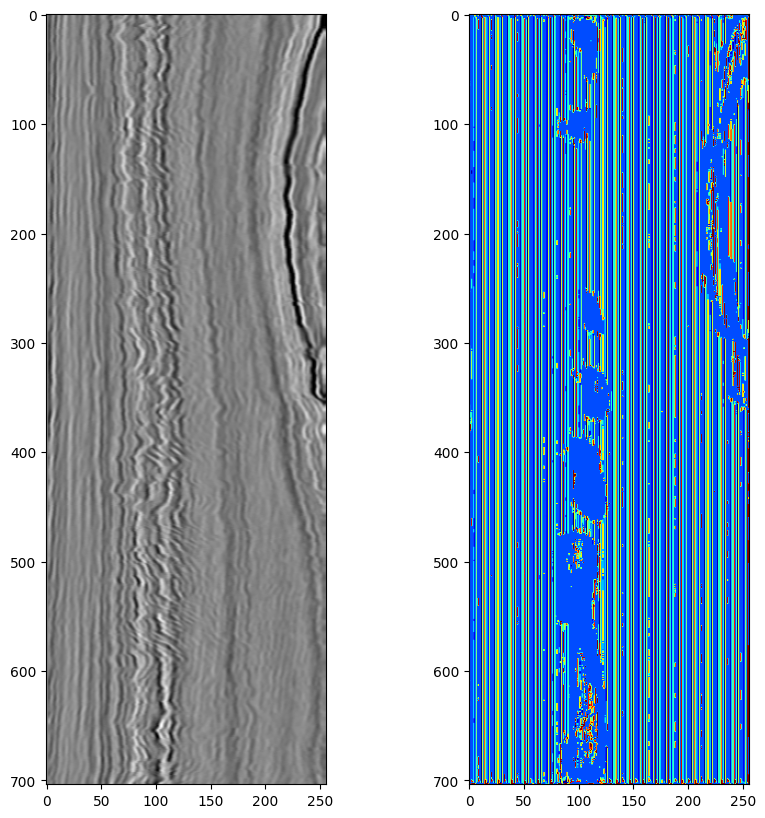

In [46]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
axs[0].imshow(image_tensor[0,0,:,:], cmap='gray')
axs[1].imshow(np.argmax(output[0,:,:,:],axis=0), cmap='jet')
# axs[1].imshow(labels[idx,:,:].T, cmap='jet')
plt.show()